## CINK calculation (integral / annual sum)

The average annual C-sink factor over a time horizon \(H\) is defined as the sum of the annual integrals of the SPC function divided by \(H\):

$$
\mathrm{CINK}(H)
= \frac{1}{H}\sum_{i=1}^{H}\int_{i-1}^{i} f_{\mathrm{SPC}}(t)\,\mathrm{d}t
$$

Since the sum of the annual integrals equals the integral over the full horizon, this is equivalent to:

$$
\mathrm{CINK}(H)
= \frac{1}{H}\int_{0}^{H} f_{\mathrm{SPC}}(t)\,\mathrm{d}t
$$

## Trapezoidal (year-step) approximation

Standards may accept an approximation of the integral by a trapezoidal Riemann sum using yearly values of \(f_{\mathrm{SPC}}(t)\):

$$
\int_{0}^{H} f(t)\,\mathrm{d}t
\approx
\sum_{k=0}^{H-1} \frac{f(k) + f(k+1)}{2}\cdot 1
$$

This yields the average annual sink factor:

$$
\mathrm{CINK}_{\mathrm{trap}}(H)
= \frac{1}{H}\sum_{k=0}^{H-1} \frac{f(k) + f(k+1)}{2}
$$


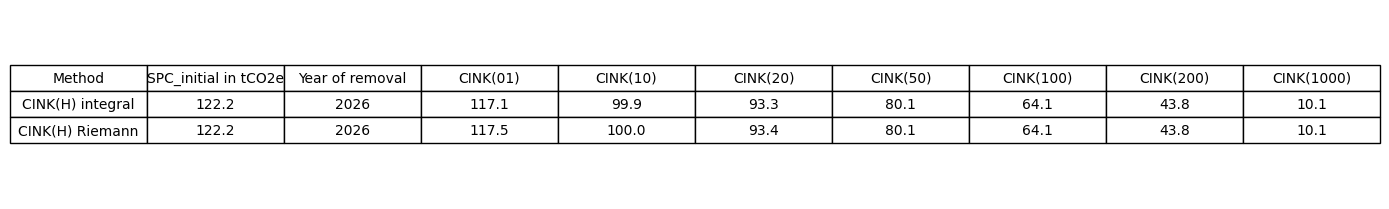

In [9]:
# CINK Calculation # CINK(H) is the average annual C-sink amount
# CINK(H) is the sum of the annual Int_SPC over each years until the end of the time horizon H divided by H to obtain the average annual sink factor.
# CINK(H) can also be calculated as Int from t=0 to H of fSPC(t)dt diveded by 0
# Standards may also accept to use the trapezoide Riemann Sum over the years until H

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- SPC retention parameters (Eq. 11; Schmidt et al., 2025)
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997

# Inputs
SPC_initial = 25.0 # is like in GBCS table # 110.8 for 1 t CH4 # change here the amount of SPC you want to calculate
year_of_removal = 2026

Hs = [1, 10, 20, 50, 100, 200, 1000] # CINK(H), add H as you like
labels = [f"CINK({h:02d})" if h < 1000 else "CINK(1000)" for h in Hs]

def f_SPC(t):
    """
    SPC retention curve:
    f_SPC(t) = a1 exp(-k1 t) + a2 exp(-k2 t)
    Works for scalar or vector t.
    """
    t = np.asarray(t, dtype=float)
    return a1_spc*np.exp(-k1*t) + a2_spc*np.exp(-k2*t)

def SPC_int_analytic(H):
    """Analytic integral: ∫_0^H f_SPC(t) dt"""
    H = float(H)
    return (
        a1_spc*(1.0 - np.exp(-k1*H))/k1 +
        a2_spc*(1.0 - np.exp(-k2*H))/k2
    )

# --- Helper: annual Int_SPC for each year i (integral from i-1 .. i)
def annual_Int_SPC(i, use_numeric=False, n=None):
    if i <= 0:
        return 0.0
    else:
        return SPC_int_analytic(i) - SPC_int_analytic(i-1)

# --- Trapezoid approximation of integral from 0..H using yearly f_SPC samples
def CINK_trapezoid(H):
    # H must be integer here
    t = np.arange(0, H + 1, 1, dtype=float)  # 0,1,...,H
    f = f_SPC(t)  # fSPC at integer years
    integral_approx = np.sum(0.5 * (f[:-1] + f[1:]) * 1.0)  # dt=1 year
    return integral_approx / H  # average annual factor



# --- Compute values: analytic (your annual integrals) and trapezoid (sampling f_SPC)
vals_analytic = []
vals_trap = []

for h in Hs:
    # Analytic/annual-integral version
    CINK_h = SPC_int_analytic(h) / h
    vals_analytic.append(CINK_h * SPC_initial)

    # Trapezoid version
    CINK_h_trap = CINK_trapezoid(h)
    vals_trap.append(CINK_h_trap * SPC_initial)

# --- Build 2-row DataFrame
df = pd.DataFrame([
    ["CINK(H) integral", SPC_initial, year_of_removal, *vals_analytic],
    ["CINK(H) Riemann", SPC_initial, year_of_removal, *vals_trap]
], columns=["Method", "SPC_initial in tCO2e", "Year of removal", *labels])

# --- Prepare formatted cell text ONLY for plotting (1 decimal)
cell_text = df.copy()
for c in labels:
    cell_text[c] = cell_text[c].map(lambda x: f"{x:.1f}")

cell_text["SPC_initial in tCO2e"] = cell_text["SPC_initial in tCO2e"].map(lambda x: f"{x:.1f}")
cell_text["Year of removal"] = cell_text["Year of removal"].astype(int).astype(str)

# --- Render as Matplotlib table
fig, ax = plt.subplots(figsize=(14, 2.2))
ax.axis("off")

fig.patch.set_facecolor("white")
ax.set_facecolor("white")

tbl = ax.table(
    cellText=cell_text.values,
    colLabels=cell_text.columns,
    cellLoc="center",
    loc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)

# Force readable colors
for (row, col), cell in tbl.get_celld().items():
    cell.set_facecolor("white")
    cell.set_text_props(color="black")
    cell.set_edgecolor("black")

plt.tight_layout()
os.makedirs("../figures", exist_ok=True)
# remove # to save the table as jpg, check the path
# plt.savefig("../figures/CINK_table_int_vs_Riem.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

## SPC–Methane Offsetting Tool (TCE/IRF framework)

The goal is to determine the mass of SPC (in tCO$_2$e at $t=0$) required to offset a given methane emission $M_{\mathrm{CH4}}$ over a specified SPC delivery horizon $H$, using the **Time-integrated Climate Effect (TCE)** framework.

## CO$_2$ impulse response function (IRF)

The atmospheric decay of a CO$_2$ pulse is represented by a multi-exponential impulse response function (Jeltsch-Thömmes, A., Joos, F., 2019. *The response to pulse-like perturbations in atmospheric carbon and carbon isotopes* 1–36.):

$$
\mathrm{IRF}(t)
= a_0 + \sum_{j=1}^{5} a_j \, e^{-t/\tau_j}
$$

with:

$$
a_0 = 0.008,\quad
(a_1,\dots,a_5)=(0.044,\;0.112,\;0.224,\;0.310,\;0.297)
$$

$$
(\tau_1,\dots,\tau_5)=(68521,\;5312,\;362,\;47,\;6)\ \text{yr}
$$

The analytic time-integral of the IRF over a horizon $T$ is:

$$
\int_{0}^{T} \mathrm{IRF}(t)\,\mathrm{d}t
= a_0\,T + \sum_{j=1}^{5} a_j \tau_j \left(1-e^{-T/\tau_j}\right)
$$

## TCE of methane emissions

Methane emissions are expressed as CO$_2$-equivalent pulse emissions using $\mathrm{GWP}_{100}$.
The time-integrated climate effect of a methane emission $M_{\mathrm{CH4}}$ over the reference horizon of 100 years is:

$$
\mathrm{TCE}_{\mathrm{CH4}}(100)
= M_{\mathrm{CH4}}\cdot \mathrm{GWP}_{100}\cdot \int_{0}^{100} \mathrm{IRF}(t)\,\mathrm{d}t
$$

The unit of TCE is $\mathrm{tCO_2e \cdot yr}$.

## TCE of an SPC sink over a horizon $H$

The retention of the sink is described by the SPC function $f_{\mathrm{SPC}}(t)$.
To compute the time-integrated climate effect of a non-permanent sink, the sink must be weighted by the CO$_2$ IRF. This yields the kernel:

$$
y(t)=f_{\mathrm{SPC}}(t)\cdot \mathrm{IRF}(t)
$$

Its integral defines:

$$
I(H)=\int_{0}^{H} f_{\mathrm{SPC}}(t)\cdot \mathrm{IRF}(t)\,\mathrm{d}t
$$

For an SPC sink of initial magnitude $M_{\mathrm{SPC}}$ (in tCO$_2$e), the corresponding TCE is:

$$
\mathrm{TCE}_{\mathrm{SPC}}(H) = -\,M_{\mathrm{SPC}} \cdot I(H)
$$

## Offset condition and required SPC mass

Offsetting is achieved when the positive methane TCE is exactly compensated by the negative SPC sink TCE:

$$
\mathrm{TCE}_{\mathrm{CH4}}(100) + \mathrm{TCE}_{\mathrm{SPC}}(H)=0
$$

Solving for the required SPC mass yields:

$$
M_{\mathrm{SPC,req}}(H)
= \frac{\mathrm{TCE}_{\mathrm{CH4}}(100)}{I(H)}
$$

## Reporting the corresponding CINK(H)

Once $M_{\mathrm{SPC,req}}$ is known, its corresponding average annual sink amount over the horizon $H$ can be reported using the CINK definition from Cell 1:

$$
\mathrm{CINK}(H)_{\mathrm{SPC}}
= M_{\mathrm{SPC,req}}(H)\cdot \frac{1}{H}\int_{0}^{H} f_{\mathrm{SPC}}(t)\,\mathrm{d}t
$$

**Note:** The methane climate effect is evaluated over a fixed **100-year** reference horizon because $\mathrm{GWP}_{100}$ is used, whereas the sink horizon $H$ is the crediting horizon and user-selected (e.g. $H=20$ years). It represents the time period over which the SPC sink is delivered and credited.


In [8]:
# SPC – Methane Offsetting Tool (TCE / IRF framework)

# -------------------------
# USER INPUTS
# -------------------------
CH4_offset = 1.0         # How much methane do you want to offset
GWP_100 = 27.0            # natural: 27.0, fossil: 29.2, mixed: 27.9
H = 20                    # offset horizon for the sink (years)

# Requires: f_SPC(t) and SPC_int_analytic(H) from Cell 1

# -------------------------
# CO2 IRF parameters (Jeltsch-Thömmes & Joos, 2019; as used in your notebooks)
# -------------------------
a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521, 5312, 362, 47, 6], dtype=float)  # years

def IRF(t):
    """
    CO2 impulse response function (IRF).
    IRF(t) = a0 + Σ a_i * exp(-t/tau_i)
    Works for scalar or vector t.
    """
    t = np.asarray(t, dtype=float)
    return a0 + np.sum(a[:, None] * np.exp(-t[None, :] / tau[:, None]), axis=0) if t.ndim == 1 else (
        a0 + np.sum(a * np.exp(-t / tau))
    )

def IRF_int(H):
    """
    Analytic integral of IRF from 0..H:
    ∫0^H IRF(t) dt = a0*H + Σ a_i * tau_i * (1 - exp(-H/tau_i))
    """
    H = float(H)
    return a0 * H + np.sum(a * tau * (1.0 - np.exp(-H / tau)))

def I_analytic(H):
    """
    Analytic integral of kernel:
    I(H) = ∫0^H f_SPC(t) * IRF(t) dt

    With f_SPC(t) = a1_spc exp(-k1 t) + a2_spc exp(-k2 t)
    and IRF(t) = a0 + Σ a_i exp(-t/tau_i)

    The integral has a closed form as a sum of exponentials:
    ∫ exp(-k t) dt = (1 - exp(-kH))/k
    ∫ exp(-(k + 1/tau) t) dt = (1 - exp(-(k + 1/tau)H)) / (k + 1/tau)
    """
    H = float(H)

    # Use SPC parameters from Cell 1 (a1_spc, k1, a2_spc, k2 must exist)
    spc_terms = [(a1_spc, k1), (a2_spc, k2)]

    total = 0.0
    for A_spc, k_spc in spc_terms:
        # Contribution from a0 term
        total += A_spc * a0 * (1.0 - np.exp(-k_spc * H)) / k_spc

        # Contributions from exponential IRF terms
        total += np.sum(
            A_spc * a * (1.0 - np.exp(-(k_spc + 1.0/tau) * H)) / (k_spc + 1.0/tau)
        )

    return total  # units: years

# -------------------------
# TCE calculation
# -------------------------
# Methane TCE over 100-year reference horizon (as in your notebook/paper)
IRFint100 = IRF_int(100)                                     # yr
TCE_methane_100 = CH4_offset * GWP_100 * IRFint100           # tCO2e·yr

# SPC TCE kernel integral over the sink horizon H
I_H = I_analytic(H)                                     # yr

# Required SPC mass at t=0 (in tCO2e)
M_SPC_required = TCE_methane_100 / I_H

# Check: SPC TCE should be -TCE_methane_100
TCE_SPC_H = -M_SPC_required * I_H

# Corresponding CINK(H_sink) for that SPC pool
CINK_factor = SPC_int_analytic(H) / H              # dimensionless
CINK_H_value = CINK_factor * M_SPC_required                  # tCO2e/yr

# -------------------------
# PRINT RESULTS
# -------------------------
print("\nSPC – Methane Offsetting Tool (TCE/IRF framework)")
print("-------------------------------------------------------------")
print(f"(1) CH4 to offset:                          {CH4_offset:.4f} t CH4")
print(f"(2) TCE_methane(100):                       {TCE_methane_100:,.2f} tCO2e·yr")
print(f"(3) Required SPC mass at t=0 (H={H}):  {M_SPC_required:,.2f} tCO2e")
print(f"(4) TCE_SPC({H}) check:                {TCE_SPC_H:,.2f} tCO2e·yr")
print(f"(5) Corresponding CINK({H}):           {CINK_H_value:,.2f} tCO2e/yr")
print("-------------------------------------------------------------")
print(f"Sanity: TCE_methane(100) + TCE_SPC({H}) = {(TCE_methane_100 + TCE_SPC_H):.4e} tCO2e·yr")




SPC – Methane Offsetting Tool (TCE/IRF framework)
-------------------------------------------------------------
(1) CH4 to offset:                          1.0000 t CH4
(2) TCE_methane(100):                       1,362.98 tCO2e·yr
(3) Required SPC mass at t=0 (H=20):  122.23 tCO2e
(4) TCE_SPC(20) check:                -1,362.98 tCO2e·yr
(5) Corresponding CINK(20):           93.32 tCO2e/yr
-------------------------------------------------------------
Sanity: TCE_methane(100) + TCE_SPC(20) = 0.0000e+00 tCO2e·yr
